# 08. PyTorch Paper Replicating Exercises

Welcome to the 08. PyTorch Paper Replicating exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/tjpW_BY8y3g) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/).

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

C:\Users\aakas\PycharmProjects\ptorch-ViT-paper-replication\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.backends.mps.is_available():
  device="mps"
elif torch.cuda.is_available():
  device="cuda"
else:
  device="cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [4]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [5]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1821f407a10>,
 ['pizza', 'steak', 'sushi'])

In [7]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

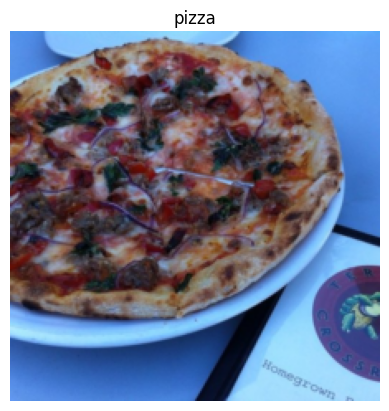

In [8]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks).
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

In [9]:
# Create the encoder layer and block
transformer_encoder = torch.nn.TransformerEncoder(
    encoder_layer=torch.nn.TransformerEncoderLayer(d_model=768,
                                                   nhead=12,
                                                   dim_feedforward=3072,
                                                   dropout=0.1,
                                                   activation="gelu",
                                                   batch_first=True,
                                                   norm_first=True),
    num_layers=12,
    norm=nn.LayerNorm(768),
    enable_nested_tensor=False)
transformer_encoder

TransformerEncoder(
  (layers): ModuleList(
    (0-11): 12 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [10]:
# Delete the transformer_encoder to preseve memory
del transformer_encoder

In [11]:
# Copying PatchEmbedding block code from another notebook
class PatchEmbedding(nn.Module):
  def __init__(self,
               image_size:int,
               color_channels:int=3, # Classification of images with 3 channels
               patch_size:int=16,
               embedding_dropout:float=0.1, # Dropout for patch and position embeddings
               embedding_dim:int=768,): # from Table1, defaults for a ViT-Base model
    """
    Returns the patch embedding for a given image in the shape of
    (batch_size, number_of_patches, embedding_dim)
    Image must be of square shape: H == W
    Args:
      image_size (int) - Image H / W, image_size % patch_size must be 0
      color_channels (int) - Number of color channels in the image
      patch_size (int) - Patch size, image_size % patch_size must be 0
      embedding_dropout (float), Dropout for patch and position embeddings
      embedding_dim (int) - Number of embedding dimensions for the vector
    """
    super().__init__()
    self.patch_size = patch_size
    assert image_size % self.patch_size == 0, f"Input image size must be divisible by patch size, image size: {image_size}, patch_size: {patch_size}"
    self.number_of_patches = int((image_size**2)/(patch_size**2)) # Assuming square image
    self.patch_and_flatten = nn.Sequential(
        nn.Conv2d(in_channels=color_channels,
                  out_channels=embedding_dim,
                  kernel_size=patch_size,
                  stride=patch_size),
        nn.Flatten(start_dim=2,
                              end_dim=3)
    )
    self.class_token = nn.Parameter(torch.rand(1,
                                               1,
                                               embedding_dim),
                                    requires_grad=True)
    self.position_embedding = nn.Parameter(torch.rand(1,
                                                      self.number_of_patches+1,
                                                      embedding_dim),
                                           requires_grad=True)
    self.dropout = nn.Dropout(p=embedding_dropout)

  def forward(self, x:torch.Tensor):
    # Get batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_token.expand(batch_size,-1,-1) # -1 means to infer the dimensions

    # Create the patch embedding (equation 1)
    x = self.patch_and_flatten(x)

    # Set the sequence embedding dimension in the right order(batch_size, number_of_patches, embedding_dimension)
    x = x.permute(0,2,1)

    # Prepend the class token
    x = torch.cat((class_token,x),
                  dim=1)

    # Add the position embedding
    x = x + self.position_embedding

    # Apply dropout to patch embedding ("directly after adding positional - to patch embeddings")
    x = self.dropout(x)
    return x

In [12]:
# Modify the ViT code to use the PyTorch transformer layer
# Create a ViT class
class ViT(nn.Module):
  def __init__(self,
               image_size:int=224, # Table 3 from the ViT paper
               patch_size:int=16,
               num_transformer_layer:int=12, # Table 1 for `Layer` for ViT-Base
               num_heads:int=12, # Table 1 for `Heads` for ViT-Base
               embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
               mlp_size:int=3072,
               mlp_dropout:float=0.1,
               embedding_dropout:int=0.1, # Dropout for patch and position embeddings
               num_classes:int=1000): # number of classes in our classification problem
    """
    Returns a ViT model based on A picture is worth 16x16 words, default values
    for ViT_Base model trained on ImageNet
    Args:
    image_size (int) = H/W dimension of the image
    patch_size (int) = H/W dimention for patch, image_size**2 // patch_size**2 must be 0
    embedding_dim (int) = Embedding dimension
    mlp_size (int) = number of nodes in the multi-layer perceptron (MLP)
    num_heads (int) = number of heads in the multihead self attention layer
    num_transformer_layer (int), number of Transformer Encoder layer in ViT-Base
    mlp_dropout (float) = dropout percentage for the MLP
    embedding_dropout (float) = deopout percentage for after embedding
    num_class (int) = number of classes in the data
    """
    super().__init__()

    # Create the patch embedding block
    self.patch_embedding_block = PatchEmbedding(
        image_size=image_size,
        patch_size=patch_size,
        embedding_dim=embedding_dim,
        embedding_dropout=embedding_dropout)

    # Create the transformer encoder block
    self.transformer_encoder = torch.nn.TransformerEncoder(
        encoder_layer=torch.nn.TransformerEncoderLayer(
        d_model=embedding_dim,
        nhead=num_heads,
        dim_feedforward=mlp_size,
        dropout=mlp_dropout,
        activation="gelu",
        batch_first=True,
        norm_first=True),
        num_layers=num_heads,
        norm=nn.LayerNorm(embedding_dim),
        enable_nested_tensor=False) # because encoder_layer.norm_first = True

    # Create classifier head
    self.classifier = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x:torch.Tensor):
    # Get position and patch embedding (equation 1)
    x = self.patch_embedding_block(x)

    # Pass position and patch embedding through transformer encoder (equations 2 and 3)
    x = self.transformer_encoder(x)

    # Put 0th index logit through the classifier
    x = self.classifier(x[:,0])
    return x

In [13]:
# Verify that the ViT works
vit = ViT(num_classes=len(class_names)) # Defaults for ViT Base
summary(model=vit,
        input_size=[32,3,224,224],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape               Output Shape              Param #                   Trainable
ViT (ViT)                                               [32, 3, 224, 224]         [32, 3]                   --                        True
├─PatchEmbedding (patch_embedding_block)                [32, 3, 224, 224]         [32, 197, 768]            152,064                   True
│    └─Sequential (patch_and_flatten)                   [32, 3, 224, 224]         [32, 768, 196]            --                        True
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]         [32, 768, 14, 14]         590,592                   True
│    │    └─Flatten (1)                                 [32, 768, 14, 14]         [32, 768, 196]            --                        --
│    └─Dropout (dropout)                                [32, 197, 768]            [32, 197, 768]            --                        --
├─TransformerEncoder (tran

## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like`from vit import ViT`.
* We covered the art of turning code cells into Python scrips in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).


In [14]:
# Create a directory for models
from pathlib import Path
models = Path("models")
models.mkdir(parents=True, exist_ok=True)

In [15]:
%%writefile models/vit.py
"""Class for creating a ViT model"""
import torch
from torch import nn

class PatchEmbedding(nn.Module):
  def __init__(self,
               image_size:int,
               color_channels:int=3,
               patch_size:int=16,
               embedding_dropout:float=0.1, # Dropout for patch and position embeddings
               embedding_dim:int=768,): # from Table1, defaults for a ViT-Base model
    """
    Returns the patch embedding for a given image in the shape of
    (batch_size, number_of_patches, embedding_dim)
    Image must be of square shape: H == W
    Args:
      image_size (int) - Image H / W, image_size % patch_size must be 0
      color_channels (int) - Number of color channels in the image
      patch_size (int) - Patch size, image_size % patch_size must be 0
      embedding_dropout (float), Dropout for patch and position embeddings
      embedding_dim (int) - Number of embedding dimensions for the vector
    """
    super().__init__()
    self.patch_size = patch_size
    assert image_size % self.patch_size == 0, f"Input image size must be divisible by patch size, image size: {image_size}, patch_size: {patch_size}"
    self.number_of_patches = int((image_size**2)/(patch_size**2)) # Assuming square image
    self.patch_and_flatten = nn.Sequential(
        nn.Conv2d(in_channels=color_channels,
                  out_channels=embedding_dim,
                  kernel_size=patch_size,
                  stride=patch_size),
        nn.Flatten(start_dim=2,
                              end_dim=3)
    )
    self.class_token = nn.Parameter(torch.rand(1,
                                               1,
                                               embedding_dim),
                                    requires_grad=True)
    self.position_embedding = nn.Parameter(torch.rand(1,
                                                      self.number_of_patches+1,
                                                      embedding_dim),
                                           requires_grad=True)
    self.dropout = nn.Dropout(p=embedding_dropout)

  def forward(self, x:torch.Tensor):
    # Get batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_token.expand(batch_size,-1,-1) # -1 means to infer the dimensions

    # Create the patch embedding (equation 1)
    x = self.patch_and_flatten(x)

    # Set the sequence embedding dimension in the right order(batch_size, number_of_patches, embedding_dimension)
    x = x.permute(0,2,1)

    # Prepend the class token
    x = torch.cat((class_token,x),
                  dim=1)

    # Add the position embedding
    x = x + self.position_embedding

    # Apply dropout to patch embedding ("directly after adding positional - to patch embeddings")
    x = self.dropout(x)
    return x

class MultiHeadSelfAttentionBlock(nn.Module):
  """Creates a mult-head self-attention block ("MSA block" for short)
  Args:
    embedding_dim (int) - Embedding dimensions, 768 by default for ViT-Base
    num_heads (int) - Number of heads for the mult-head self-attention
    attn_dropout (float) - Dropout rate for multihead self attention
  """
  def __init__(self,
               embedding_dim:int=768, # Hidden size D (embedding dimension) from Table 1 for ViT-Base
               num_heads:int=12, # Heads from Table 1 for ViT-Base
               attn_dropout:float=0):
    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create multihead attention (MSA) layer
    self.multi_head_attention = nn.MultiheadAttention(
        embed_dim=embedding_dim,
        num_heads=num_heads,
        dropout=attn_dropout,
        batch_first=True) # is the batch first? (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension)

  def forward(self, x:torch.Tensor):
    normalized_x = self.layer_norm(x)
    attn_output, _ = self.multi_head_attention(query=normalized_x,
                                               key=normalized_x,
                                               value=normalized_x,
                                               need_weights=False)
    return attn_output

class MLPBlock(nn.Module):
  """Takes the output of the MSA block and returns the prediction logits added
  to the input.
  Args:
    embedding_dim (int) = Embedding dimension, default 768 for ViT-Base
    mlp_size (int) = Features for MLP block, default 768 for ViT-Base
    dropout (float) = Dropout rate between 0 and 1, default 0.1 for ViT-Base
  """
  def __init__(self,
               embedding_dim:int=768,
               mlp_size=3072,
               dropout:float=0.1):
    super().__init__()

    # Create the layer norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x:torch.Tensor):
    normalized_x = self.layer_norm(x)
    mlp_x = self.mlp(normalized_x)
    return mlp_x

class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768, # Hidden size D (embedding dimension) from Table 1 for ViT-Base
               num_heads:int=12, # Heads from Table 1 for ViT-Base
               attn_dropout:float=0,
               mlp_size=3072,
               mlp_dropout:float=0.1):
    """
    Passes embedded patches through a multihead self attention (MSA) block and
    multilayer perceptron (MLP) block
    Args:
      embedding_dim (int) - Embedding dimension for the vector, 769 for ViT-Base
      num_heads (int) - Number of heads for the mult-head self-attention
      attn_dropout (float) - Dropout rate for multihead self attention
      mlp_size (int) = Features for MLP block, default 768 for ViT-Base
      mlp_dropout (float) = Dropout rate between 0 and 1, default 0.1 for ViT-Base
    """
    super().__init__()

    # Create MSA block (equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(
        embedding_dim=embedding_dim,
        num_heads=num_heads,
        attn_dropout=attn_dropout
    )

    # Create MLP block (equation 3)
    self.mlp_block = MLPBlock(
        embedding_dim=embedding_dim,
        mlp_size=mlp_size,
        dropout=mlp_dropout
    )

  def forward(self, x:torch.Tensor):
    x = self.msa_block(x) + x # residual/skip connection for equation 2
    x = self.mlp_block(x) + x # residual/skip connection for equation 3
    return x

# ViT model class
class ViT(nn.Module):
  def __init__(self,
               image_size:int=224, # Table 3 from the ViT paper
               patch_size:int=16,
               num_transformer_layer:int=12, # Table 1 for `Layer` for ViT-Base
               num_heads:int=12, # Table 1 for 'Heads' for ViT-Base
               embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
               mlp_size:int=3072,
               attn_dropout:float=0,
               mlp_dropout:float=0.1,
               embedding_dropout:int=0.1, # Dropout for patch and position embeddings
               num_classes:int=1000): # number of classes in our classification problem
    """
    Returns a ViT model based on A picture is worth 16x16 words, default values
    for ViT_Base model trained on ImageNet
    Args:
    image_size (int) = H/W dimension of the image
    patch_size (int) = H/W dimention for patch, image_size**2 // patch_size**2 must be 0
    embedding_dim (int) = Embedding dimension
    mlp_size (int) = number of nodes in the multi-layer perceptron (MLP)
    num_heads (int) = number of heads in the multihead self attention layer
    num_transformer_layer (int), number of Transformer Encoder layer in ViT-Base
    mlp_dropout (float) = dropout percentage for the MLP
    embedding_dropout (float) = deopout percentage for after embedding
    num_class (int) = number of classes in the data
    """
    super().__init__()

    # Create the patch embedding block
    self.patch_embedding_block = PatchEmbedding(
        image_size=image_size,
        patch_size=patch_size,
        embedding_dim=embedding_dim,
        embedding_dropout=embedding_dropout)

    # Create the transformer encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(
        embedding_dim=embedding_dim,
        num_heads=num_heads,
        attn_dropout=attn_dropout,
        mlp_size=mlp_size,
        mlp_dropout=mlp_dropout
    ) for _ in range(num_transformer_layer)])

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create classifier head
    self.classifier = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x:torch.Tensor):
    # Get position and patch embedding (equation 1)
    x = self.patch_embedding_block(x)

    # Pass position and patch embedding through transformer encoder (equations 2 and 3)
    x = self.transformer_encoder(x)

    # Layer norm for the output of the transformer encoder
    x = self.layer_norm(x)

    # Put 0th index logit through the classifier
    x = self.classifier(x[:,0])
    return x

Writing models/vit.py


## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets)
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

### 3.1 Update the engine.py file
Allows the module to:
1. Take in lr scheduler for warmup and decay
2. Gradient clipping

In [16]:
%%writefile going_modular/going_modular/engine.py
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               lr_scheduler:torch.optim.lr_scheduler,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    lr_scheduler: Learning Rate scheduler for the optimizer
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Keep track of the number of optimizer steps
    global_steps = 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # Gradient clipping at global norm = 1, Table 3 of the ViT paper
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # 5. Optimizer step
        optimizer.step()
        # LR scheduling every step
        lr_scheduler.step()
        # Keep track of global_steps for debugging purposes
        global_steps+=1

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    lr_scheduler: Learning Rate scheduler for the optimizer
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          lr_scheduler:torch.optim.lr_scheduler,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    lr_scheduler: Learning Rate scheduler for the optimizer
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          lr_scheduler=lr_scheduler,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

Overwriting going_modular/going_modular/engine.py


In [17]:
# Reimport engine.py with the updated train function
import importlib
importlib.reload(engine)

<module 'going_modular.going_modular.engine' from 'C:\\Users\\aakas\\PycharmProjects\\ptorch-ViT-paper-replication\\going_modular\\going_modular\\engine.py'>

### 3.2 Get the pre-trained ViT extractor model
1. Freeze the layers
2. Change the classifer head
3. Get the transform for the model

In [18]:
from torchvision import models as TM
pretrained_vit = TM.vit_b_16(weights=TM.ViT_B_16_Weights.DEFAULT)
pretrained_transform = TM.ViT_B_16_Weights.DEFAULT.transforms()

In [19]:
# Freeze all the layers
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

In [20]:
# Setup the classifier head
pretrained_vit.heads = nn.Linear(in_features=pretrained_vit.heads.head.in_features,
                                 out_features=len(class_names))

In [21]:
# Set the model to device
pretrained_vit.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [22]:
# Verify the changes work as intended
summary(model=pretrained_vit,
        input_size=[1,3,224,224],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]          [1, 3]                    768                       Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]          [1, 768, 14, 14]          (590,592)                 False
├─Encoder (encoder)                                          [1, 197, 768]             [1, 197, 768]             151,296                   False
│    └─Dropout (dropout)                                     [1, 197, 768]             [1, 197, 768]             --                        --
│    └─Sequential (layers)                                   [1, 197, 768]             [1, 197, 768]             --                        False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]             [1, 197, 768]             (7,087,872)   

### 3.3 Setup the hyperparameters

In [23]:
BATCH_SIZE=32
EPOCHS=10

### 3.3 Get the data

In [24]:
from helper_functions import download_data
image_path_20_percent = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi_20_percent.zip",
    destination="pizza_steak_sushi_20_percent")

[INFO] Did not find data\pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


### 3.4 Preprocess the data

In [25]:
# Setup train and test dir
train_dir = image_path_20_percent/"train"
test_dir = image_path_20_percent/"test"
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

In [26]:
# Create dataloaders
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=pretrained_transform,
    batch_size=BATCH_SIZE
)

### 3.5 Setup optimizer and loss function

In [27]:
# Calculate the warmup and decay steps
total_steps = EPOCHS*len(train_dataloader_20_percent)
warmup_steps = int(total_steps*0.05)
decay_steps = total_steps - warmup_steps
print(f"Total steps: {total_steps}, warmup steps: {warmup_steps}, decay steps: {decay_steps}")

Total steps: 150, warmup steps: 7, decay steps: 143


In [28]:
# Create the optimizer
optimizer = torch.optim.Adam(
    params=pretrained_vit.parameters(), # only classifer is trainable so no exclusions from weight decay
    lr=1e-3,
    weight_decay=0.03
)

In [29]:
# Setup the warmup and decay lr schedulers
warmup_scheduler=torch.optim.lr_scheduler.LinearLR(
    optimizer=optimizer,
    start_factor=1e-6,
    end_factor=1,
    total_iters=warmup_steps
)
decay_scheduler=torch.optim.lr_scheduler.LinearLR(
    optimizer=optimizer,
    start_factor=1,
    end_factor=0,
    total_iters=decay_steps
)
lr_scheduler=torch.optim.lr_scheduler.SequentialLR(
    optimizer=optimizer,
    schedulers=[warmup_scheduler, decay_scheduler],
    milestones=[warmup_steps]
)

In [30]:
# Create the loss function
loss_fn=nn.CrossEntropyLoss()

### 3.5 Train the model

In [31]:
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_20_percent,
                                      test_dataloader=test_dataloader_20_percent,
                                      optimizer=optimizer,
                                      lr_scheduler=lr_scheduler,
                                      loss_fn=loss_fn,
                                      epochs=EPOCHS,
                                      device=device)

 10%|█         | 1/10 [00:38<05:45, 38.41s/it]

Epoch: 1 | train_loss: 0.8929 | train_acc: 0.5833 | test_loss: 0.3515 | test_acc: 0.9256


 20%|██        | 2/10 [01:10<04:37, 34.66s/it]

Epoch: 2 | train_loss: 0.2513 | train_acc: 0.9354 | test_loss: 0.1307 | test_acc: 0.9659


 30%|███       | 3/10 [01:39<03:44, 32.09s/it]

Epoch: 3 | train_loss: 0.1507 | train_acc: 0.9500 | test_loss: 0.0912 | test_acc: 0.9812


 40%|████      | 4/10 [02:13<03:16, 32.71s/it]

Epoch: 4 | train_loss: 0.1148 | train_acc: 0.9646 | test_loss: 0.0775 | test_acc: 0.9812


 50%|█████     | 5/10 [02:40<02:34, 30.82s/it]

Epoch: 5 | train_loss: 0.0940 | train_acc: 0.9750 | test_loss: 0.0709 | test_acc: 0.9812


 60%|██████    | 6/10 [03:08<01:59, 29.94s/it]

Epoch: 6 | train_loss: 0.0840 | train_acc: 0.9792 | test_loss: 0.0694 | test_acc: 0.9875


 70%|███████   | 7/10 [03:38<01:29, 29.72s/it]

Epoch: 7 | train_loss: 0.0779 | train_acc: 0.9812 | test_loss: 0.0684 | test_acc: 0.9812


 80%|████████  | 8/10 [04:10<01:00, 30.48s/it]

Epoch: 8 | train_loss: 0.0957 | train_acc: 0.9812 | test_loss: 0.0655 | test_acc: 0.9812


 90%|█████████ | 9/10 [04:35<00:28, 28.90s/it]

Epoch: 9 | train_loss: 0.0735 | train_acc: 0.9812 | test_loss: 0.0646 | test_acc: 0.9875


100%|██████████| 10/10 [05:03<00:00, 30.35s/it]

Epoch: 10 | train_loss: 0.0688 | train_acc: 0.9833 | test_loss: 0.0642 | test_acc: 0.9875


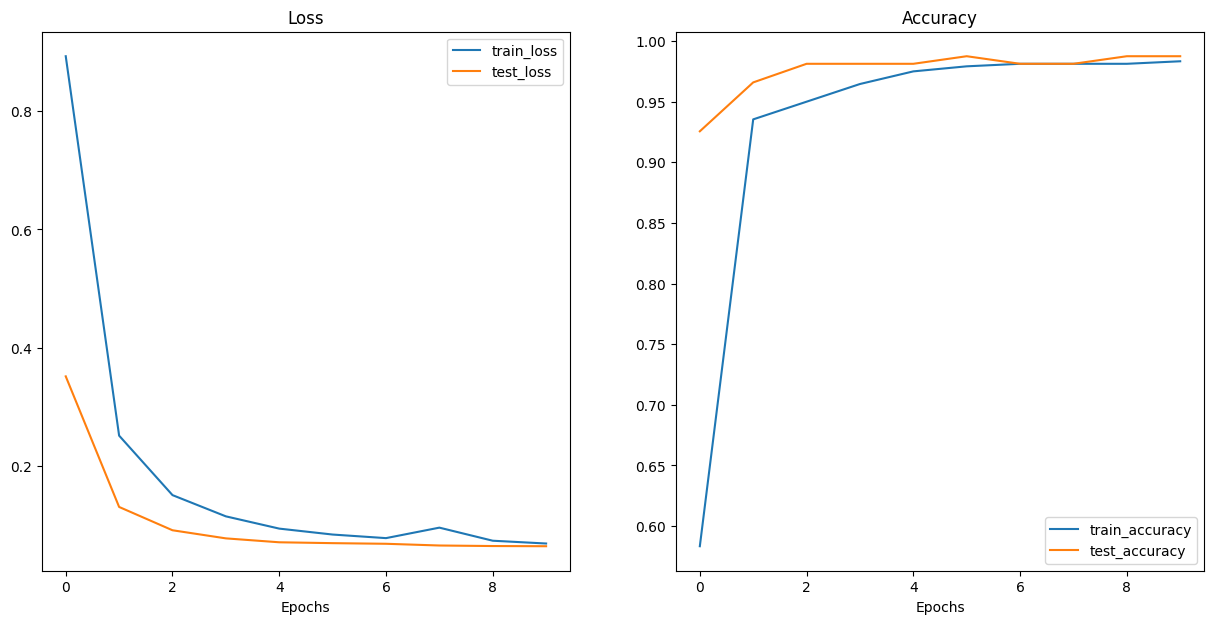

In [32]:
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_results)

Excellent results with both train and test data with high accuracy and no overfitting.

The results are better than what we previously saw with EffNetB2 model in https://github.com/AvalonEnjoyer/pytorch-experiment-tracking/blob/master/07_pytorch_experiment_tracking_self.ipynb section 3. However, the model is significantly larger.

## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.
* Note: Using the same batch size, epochs from exercise 3

### 4.1 Setup the pretrained model and get the transform

In [33]:
swag_pretrained_vit = TM.vit_b_16(weights=TM.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1)
swag_transform = TM.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1.transforms()

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to C:\Users\aakas/.cache\torch\hub\checkpoints\vit_b_16_swag-9ac1b537.pth


100%|██████████| 331M/331M [00:54<00:00, 6.36MB/s] 


In [34]:
# Freeze all the layers
for parameter in swag_pretrained_vit.parameters():
  parameter.requires_grad = False

In [35]:
# Set up the classifier head
swag_pretrained_vit.heads = nn.Linear(
    in_features=swag_pretrained_vit.heads.head.in_features,
    out_features=len(class_names))

In [36]:
swag_pretrained_vit.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [37]:
# Verify that the model is working
summary(model=swag_pretrained_vit,
        input_size=[1,3,384,384],
        col_names=["input_size","output_size","num_params","trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 384, 384]          [1, 3]                    768                       Partial
├─Conv2d (conv_proj)                                         [1, 3, 384, 384]          [1, 768, 24, 24]          (590,592)                 False
├─Encoder (encoder)                                          [1, 577, 768]             [1, 577, 768]             443,136                   False
│    └─Dropout (dropout)                                     [1, 577, 768]             [1, 577, 768]             --                        --
│    └─Sequential (layers)                                   [1, 577, 768]             [1, 577, 768]             --                        False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 577, 768]             [1, 577, 768]             (7,087,872)   

### 4.3 Preprocess data and setup DataLoaders

In [38]:
train_dataloader_swag, test_dataloader_swag, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=swag_transform,
    batch_size=BATCH_SIZE
)

### 4.4 Setup optimizer and loss function

#### 4.4.1 As we're using the same number of epochs and batch size warmup steps and decay steps are the same as exercise 3

In [39]:
# Create optimizer
optimizer=torch.optim.Adam(params=swag_pretrained_vit.parameters(),
                           lr=1e-3,
                           weight_decay=0.03)

In [40]:
# Create lr warmup and decay scheduler
from torch.optim import lr_scheduler
warmup_scheduler=lr_scheduler.LinearLR(
    optimizer=optimizer,
    start_factor=1e-6,
    end_factor=1,
    total_iters=warmup_steps
)
decay_scheduler=lr_scheduler.LinearLR(
    optimizer=optimizer,
    start_factor=1,
    end_factor=0,
    total_iters=decay_steps
)
lr_scheduler=lr_scheduler.SequentialLR(
    optimizer=optimizer,
    schedulers=[warmup_scheduler,decay_scheduler],
    milestones=[warmup_steps]
)

#### 4.4.2 Create loss function

In [41]:
# Create loss function
loss_fn = nn.CrossEntropyLoss()

### 4.5 Train the model

In [42]:
swag_pretrained_vit_results = engine.train(model=swag_pretrained_vit,
                                           train_dataloader=train_dataloader_swag,
                                           test_dataloader=test_dataloader_swag,
                                           optimizer=optimizer,
                                           loss_fn=loss_fn,
                                           lr_scheduler=lr_scheduler,
                                           epochs=EPOCHS,
                                           device=device)

 10%|█         | 1/10 [00:36<05:25, 36.20s/it]

Epoch: 1 | train_loss: 0.8363 | train_acc: 0.6542 | test_loss: 0.0439 | test_acc: 1.0000


 20%|██        | 2/10 [01:09<04:36, 34.57s/it]

Epoch: 2 | train_loss: 0.0611 | train_acc: 0.9792 | test_loss: 0.0052 | test_acc: 1.0000


 30%|███       | 3/10 [01:42<03:57, 33.88s/it]

Epoch: 3 | train_loss: 0.0305 | train_acc: 0.9938 | test_loss: 0.0034 | test_acc: 1.0000


 40%|████      | 4/10 [02:14<03:19, 33.17s/it]

Epoch: 4 | train_loss: 0.0183 | train_acc: 0.9979 | test_loss: 0.0032 | test_acc: 1.0000


 50%|█████     | 5/10 [02:48<02:47, 33.51s/it]

Epoch: 5 | train_loss: 0.0121 | train_acc: 0.9979 | test_loss: 0.0032 | test_acc: 1.0000


 60%|██████    | 6/10 [03:21<02:12, 33.06s/it]

Epoch: 6 | train_loss: 0.0093 | train_acc: 0.9979 | test_loss: 0.0034 | test_acc: 1.0000


 70%|███████   | 7/10 [03:55<01:40, 33.46s/it]

Epoch: 7 | train_loss: 0.0078 | train_acc: 0.9979 | test_loss: 0.0032 | test_acc: 1.0000


 80%|████████  | 8/10 [04:27<01:06, 33.06s/it]

Epoch: 8 | train_loss: 0.0068 | train_acc: 1.0000 | test_loss: 0.0029 | test_acc: 1.0000


 90%|█████████ | 9/10 [05:00<00:32, 32.93s/it]

Epoch: 9 | train_loss: 0.0056 | train_acc: 1.0000 | test_loss: 0.0029 | test_acc: 1.0000


100%|██████████| 10/10 [05:29<00:00, 32.99s/it]

Epoch: 10 | train_loss: 0.0054 | train_acc: 1.0000 | test_loss: 0.0030 | test_acc: 1.0000


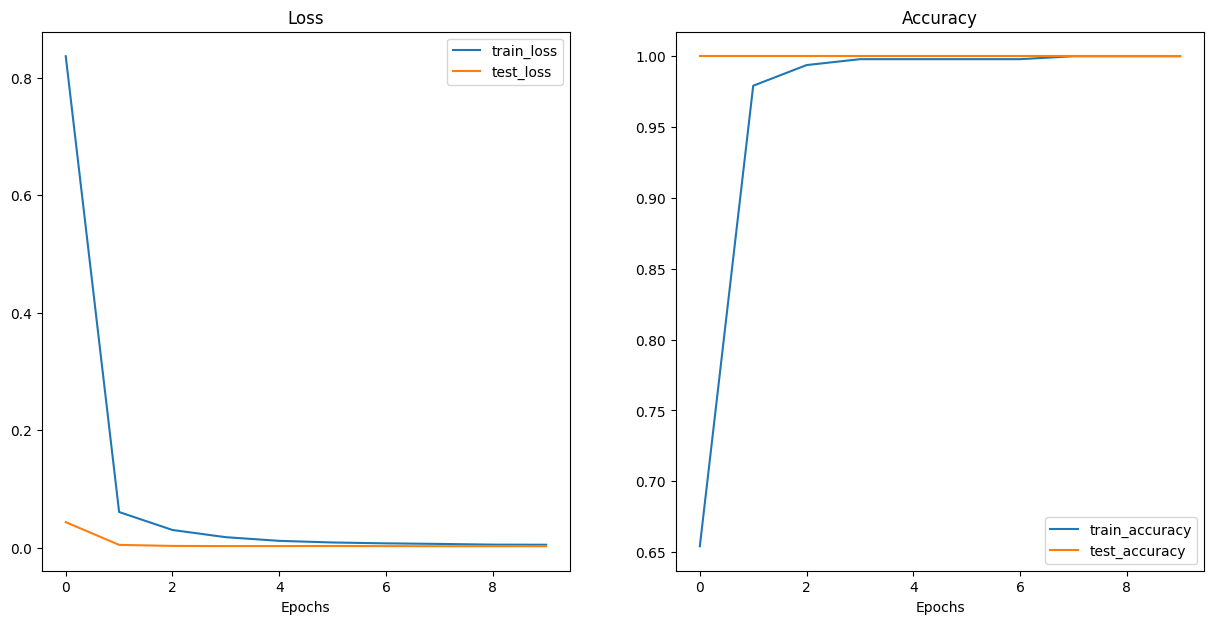

In [43]:
plot_loss_curves(swag_pretrained_vit_results)

Phenomenal results with perfect accuracy and very low losses on both train and test datasets. Increase in image resolution has helped the model achieve even better results.

# 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things.
* Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
    * **ImageNet-21k pretraining**
    * **Learning rate warmup**
    * **Learning rate decay**
    * **Gradient clipping**

I have already implemented learning rate warmup, learning rate decay, and gradient clipping in my tests. They are regularization techniques with the first two managing the lr throughout the optimizer steps (not epochs).
Gradient clipping normalizes the gradients and prevents problems created by gradients of different sizes which can cause explosion of loss values.

ImageNet-21k is a large dataset with 21k classes and 14M images which is the superset of  ImageNet-1k with with 1k classes and 1.3M images.

As the paper states in page 2, pre-training on the ImageNet-21k datasets enables ViT to approach or beat state of the art (SOTA) models on multiple image recognition benchmarks.

I do not have the resources to be able to train the model on such a large dataset, but if I had it would enable me to achieve results similar to what the authors of the paper have shown.